In [14]:
!pip install pandas
!pip install matplotlib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

stock_data = pd.read_csv('stock_data_weak.csv')
print(stock_data)

          Date  General Electric  Chesapeake Energy   AT&T  Cisco Systems  \
0   12/31/2007             37.08              39.36  42.12          27.25   
1    3/31/2008             36.63              45.76  37.71          24.08   
2    6/30/2008             26.35              66.77  32.75          23.47   
3    9/30/2008             23.87              33.29  28.35          22.25   
4   12/31/2008             15.82              15.34  28.19          16.18   
5    3/31/2009             10.33              17.65  25.44          16.53   
6    6/30/2009             11.84              19.72  25.14          18.94   
7    9/30/2009             16.83              28.80  27.34          23.55   
8   12/31/2009             15.27              26.36  28.29          24.10   
9    3/31/2010             18.21              23.52  25.90          26.52   
10   6/30/2010             14.47              21.47  24.35          21.52   
11   9/30/2010             16.46              22.66  28.78          22.05   

In [17]:
selected = list(stock_data.columns[1:])
returns_quarterly = stock_data[selected].pct_change()
print(returns_quarterly)

    General Electric  Chesapeake Energy      AT&T  Cisco Systems  \
0                NaN                NaN       NaN            NaN   
1          -0.012136           0.162602 -0.104701      -0.116330   
2          -0.280644           0.459135 -0.131530      -0.025332   
3          -0.094118          -0.501423 -0.134351      -0.051981   
4          -0.337243          -0.539201 -0.005644      -0.272809   
5          -0.347029           0.150587 -0.097552       0.021632   
6           0.146176           0.117280 -0.011792       0.145796   
7           0.421453           0.460446  0.087510       0.243400   
8          -0.092692          -0.084722  0.034748       0.023355   
9           0.192534          -0.107739 -0.084482       0.100415   
10         -0.205382          -0.087160 -0.059846      -0.188537   
11          0.137526           0.055426  0.181930       0.024628   
12          0.102673           0.142542  0.020153      -0.082086   
13          0.106336           0.335651  0.04325

In [18]:
expected_returns = returns_quarterly.mean()
print(expected_returns)

General Electric    -0.012048
Chesapeake Energy   -0.030608
AT&T                -0.001464
Cisco Systems        0.018479
Campbell Soup        0.008469
dtype: float64


In [20]:
cov_quarterly = returns_quarterly.cov()
print(expected_returns)

General Electric    -0.012048
Chesapeake Energy   -0.030608
AT&T                -0.001464
Cisco Systems        0.018479
Campbell Soup        0.008469
dtype: float64


In [21]:
def return_portfolios(expected_returns, cov_matrix):
    port_returns = []
    port_volatility = []
    stock_weights = []
    
    selected = (expected_returns.axes)[0]
    
    num_assets = len(selected)
    num_portfolios = 5000
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
        
    portfolio = {'Returns': port_returns, 'Volatility': port_volatility}
    
    for counter, symbol in enumerate(selected):
        portfolio[symbol + 'Weight'] = [Weight[counter] for Weight in stock_weights]
        
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock+'Weight' for stock in selected]
    
    df = df[column_order]
    
    return df

In [22]:
random_portfolios = return_portfolios(expected_returns, cov_quarterly)
print(random_portfolios)

           Returns  Volatility  General ElectricWeight  \
0    -1.056239e-02    0.109997                0.261581   
1    -3.763749e-07    0.101376                0.058496   
2    -4.179135e-03    0.095543                0.204948   
3    -2.829286e-03    0.104929                0.021659   
4    -2.727784e-03    0.098254                0.234128   
...            ...         ...                     ...   
4995  8.180259e-04    0.081841                0.230026   
4996  2.779385e-04    0.078911                0.073917   
4997 -3.665654e-03    0.094804                0.112677   
4998 -6.141616e-03    0.103439                0.416569   
4999 -1.371052e-02    0.126475                0.286797   

      Chesapeake EnergyWeight  AT&TWeight  Cisco SystemsWeight  \
0                    0.309826    0.231008             0.073636   
1                    0.275064    0.098905             0.445762   
2                    0.227817    0.135360             0.180188   
3                    0.335869    0.1012

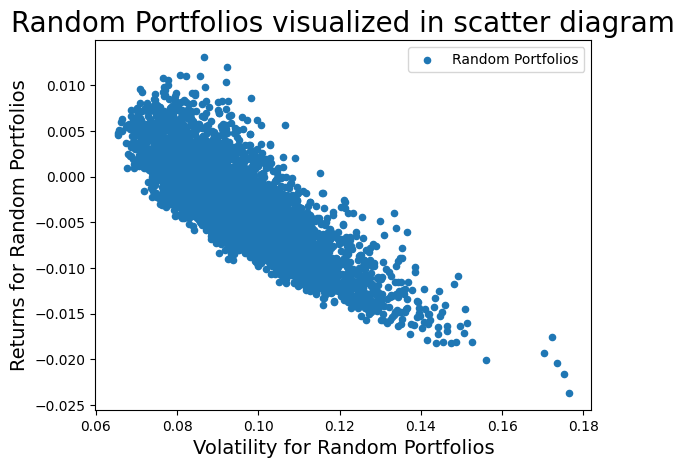

In [43]:
random_portfolios.plot.scatter('Volatility', 'Returns')
ax = plt.subplot()
ax.set_xlabel('Volatility for Random Portfolios', fontsize = '14')
ax.set_ylabel('Returns for Random Portfolios', fontsize = '14')
ax.set_title('Random Portfolios visualized in scatter diagram', fontsize = '20')
plt.legend(['Random Portfolios'])

In [32]:
 %conda install cvxopt
import cvxopt as opt
from cvxopt import blas, solvers

def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.values)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n)) # negative n x n identity matrix
    h = opt.matrix(0.0, (n,1))
    A = opt.matrix(1.0, (1,n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

Channels:
 - defaults
Platform: osx-64
Solving environment: done

## Package Plan ##

  environment location: /opt/miniconda3

  added / updated specs:
    - cvxopt


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |         openblas          45 KB
    certifi-2024.6.2           |  py312hecd8cb5_0         162 KB
    conda-24.5.0               |  py312hecd8cb5_0         1.2 MB
    cvxopt-1.3.0               |  py312h66d9559_0         492 KB
    dsdp-5.8                   |       h5e1e2ef_2         247 KB
    fftw-3.3.9                 |       h6c40b1e_2         3.8 MB
    frozendict-2.4.2           |  py312hecd8cb5_0          38 KB
    glpk-4.65                  |       h05f8d05_3         712 KB
    gmp-6.2.1                  |       he9d5cce_3         525 KB
    gsl-2.7.1                  |       hdbe807d_1         2.2 MB
    libgfortran-5.0.0          |11_3_0_

In [34]:
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

     pcost       dcost       gap    pres   dres
 0:  2.3517e-03 -1.0183e+00  1e+00  1e-16  3e+00
 1:  1.8118e-03 -2.8254e-02  3e-02  8e-17  8e-02
 2: -1.4950e-02 -1.9458e-02  5e-03  1e-16  1e-17
 3: -1.7780e-02 -1.7871e-02  9e-05  2e-16  2e-17
 4: -1.7834e-02 -1.7835e-02  9e-07  1e-16  1e-17
 5: -1.7835e-02 -1.7835e-02  9e-09  4e-16  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.3950e-03 -1.0182e+00  1e+00  3e-16  3e+00
 1:  1.8529e-03 -2.8227e-02  3e-02  8e-17  8e-02
 2: -1.4853e-02 -1.9394e-02  5e-03  2e-16  2e-17
 3: -1.7699e-02 -1.7791e-02  9e-05  3e-16  8e-18
 4: -1.7756e-02 -1.7757e-02  9e-07  2e-16  1e-17
 5: -1.7756e-02 -1.7756e-02  9e-09  2e-16  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.4435e-03 -1.0182e+00  1e+00  2e-16  3e+00
 1:  1.8989e-03 -2.8196e-02  3e-02  4e-17  8e-02
 2: -1.4745e-02 -1.9323e-02  5e-03  2e-16  2e-17
 3: -1.7609e-02 -1.7701e-02  9e-05  2e-16  1e-17
 4: -1.7667e-02 -1.7668e

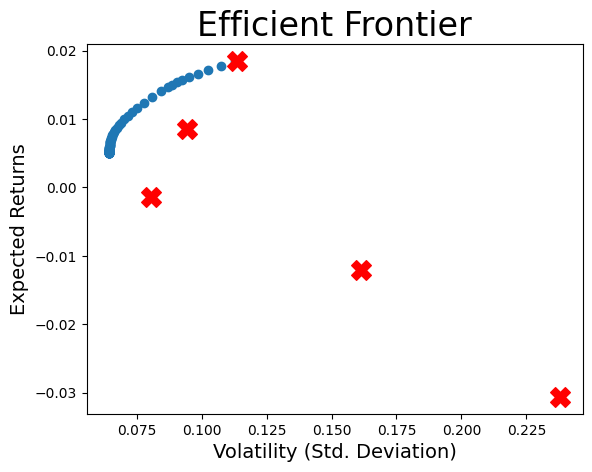

In [47]:
plt.scatter(risks, returns)
plt.ylabel('Expected Returns', fontsize=14)
plt.xlabel('Volatility (Std. Deviation)', fontsize=14)
plt.title('Efficient Frontier', fontsize=24)
single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)

plt.show()

     pcost       dcost       gap    pres   dres
 0: -1.0662e-02 -1.0359e+00  1e+00  0e+00  3e+00
 1: -1.1534e-02 -4.5915e-02  3e-02  1e-16  1e-01
 2: -3.2498e-02 -3.8737e-02  6e-03  4e-16  2e-03
 3: -3.4247e-02 -3.4697e-02  4e-04  1e-16  1e-04
 4: -3.4442e-02 -3.4469e-02  3e-05  2e-16  5e-07
 5: -3.4446e-02 -3.4446e-02  4e-07  2e-16  5e-09
 6: -3.4446e-02 -3.4446e-02  4e-09  1e-16  5e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0582e-02 -1.0358e+00  1e+00  1e-16  3e+00
 1: -1.1451e-02 -4.5792e-02  3e-02  7e-17  1e-01
 2: -3.2227e-02 -3.8492e-02  6e-03  2e-16  2e-03
 3: -3.4012e-02 -3.4437e-02  4e-04  2e-16  8e-05
 4: -3.4193e-02 -3.4213e-02  2e-05  6e-17  7e-07
 5: -3.4196e-02 -3.4196e-02  2e-07  2e-16  7e-09
 6: -3.4196e-02 -3.4196e-02  2e-09  1e-22  7e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0492e-02 -1.0357e+00  1e+00  0e+00  3e+00
 1: -1.1358e-02 -4.5653e-02  3e-02  9e-17  1e-01
 2: -3.1924e-02 -3.8217e

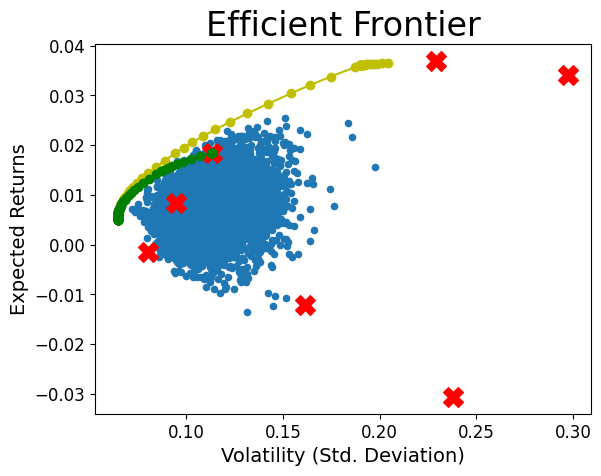

In [52]:
path = 'stock_data2.csv'

stock_data = pd.read_csv(path)

selected = list(stock_data.columns[1:])
returns_quarterly = stock_data[selected].pct_change()

expected_returns = returns_quarterly.mean()

cov_quarterly = returns_quarterly.cov()

random_portfolios = return_portfolios(expected_returns, cov_quarterly)

random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)

weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)

single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)

weak_EF = pd.read_csv('weak_risks_returns.csv')
plt.plot(weak_EF['Risks'], weak_EF['Returns'], 'g-o')

plt.show()

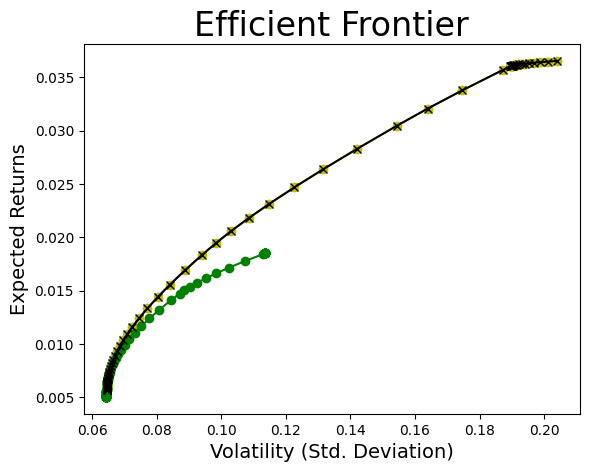

In [54]:
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)
weak_EF = pd.read_csv('weak_risks_returns.csv')
plt.plot(weak_EF['Risks'], weak_EF['Returns'], 'g-o')
strong_EF = pd.read_csv('strong_risks_returns.csv')
plt.plot(strong_EF['Risks'], strong_EF['Returns'], 'k-x')


PFE    0.015530
TGT    0.014783
M      0.021962
VZ     0.004856
JPM    0.034781
MRO   -0.008010
KO    -0.002050
PG     0.004132
CVS    0.016124
HPQ   -0.000237
dtype: float64
          PFE       TGT         M        VZ       JPM       MRO        KO  \
PFE  0.010005  0.001738  0.005978  0.004071  0.007016  0.009721  0.002086   
TGT  0.001738  0.012874  0.015762  0.002188  0.007805  0.002239  0.002534   
M    0.005978  0.015762  0.038909  0.002804  0.016439  0.015110  0.005189   
VZ   0.004071  0.002188  0.002804  0.006958 -0.000407  0.005276  0.002586   
JPM  0.007016  0.007805  0.016439 -0.000407  0.023837  0.013848  0.002979   
MRO  0.009721  0.002239  0.015110  0.005276  0.013848  0.043166 -0.001516   
KO   0.002086  0.002534  0.005189  0.002586  0.002979 -0.001516  0.011021   
PG   0.004297  0.003148  0.005853  0.002094  0.006364  0.002834  0.001255   
CVS  0.004300  0.005384  0.012501  0.002052  0.005041  0.003689  0.003223   
HPQ  0.006996  0.007774  0.018937  0.003076  0.011523  

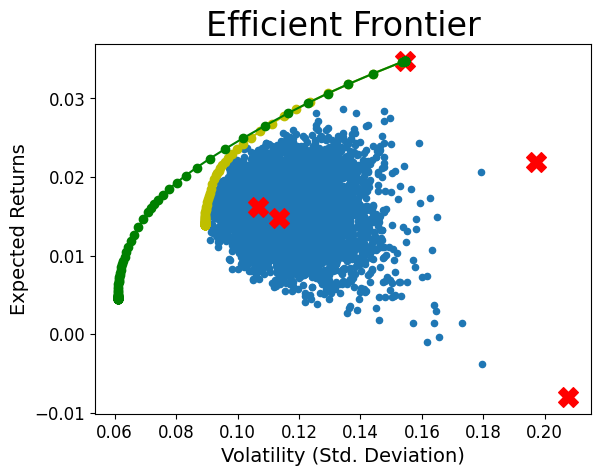

In [57]:
path='stock_data3.csv'

stock_data = pd.read_csv(path)
selected = list(stock_data.columns[1:])
print(stock_data[selected].pct_change().mean())
print(stock_data[selected].pct_change().cov())

selected = ['MRO', 'TGT', 'JPM', 'M', 'CVS']

returns_quarterly = stock_data[selected].pct_change()

expected_returns = returns_quarterly.mean()

cov_quarterly = returns_quarterly.cov()

random_portfolios = return_portfolios(expected_returns, cov_quarterly) 

random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)

weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)

#pd.DataFrame({'Risks': risks, 'Returns': returns}).to_csv('all_ten.csv', index=False)

single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)

all_ten_EF = pd.read_csv('all_ten.csv')
plt.plot(all_ten_EF['Risks'], all_ten_EF['Returns'], 'g-o')
plt.show()